In [103]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

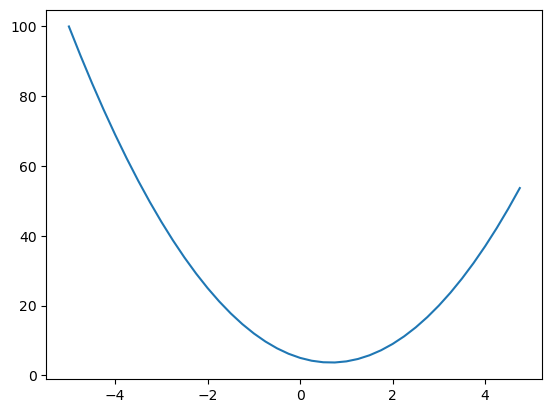

In [7]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [9]:
#türev
h = 0.000001
x = 3.0
(f(x + h) - f(x))/h

14.000003002223593

In [11]:
# Biraz daha karmaşıklaştıralım
a= 2.0
b= -3.0
c= 10.0
d= a*b + c
print(d)


4.0


In [13]:
h= 0.0001

#Girdiler
a= 2.0
b= -3.0
c= 10.0

d1 = a*b +c
a+= h
d2 = a*b +c

print('d1',d1)
print('d2',d2)
print('Eğim',(d2-d1)/h)


d1 4.0
d2 3.999699999999999
Eğim -3.000000000010772


### Otomatik Türev Sınıfı (`Value`)
Bu sınıf, bir skalar değeri ve ona bağlı gradyanı (türev bilgisini) temsil eder.  
Her matematiksel işlemde yeni `Value` nesneleri oluşturularak **hesap grafiği (computational graph)** kurulur.  
`backward()` çağrıldığında bu grafikteki düğümler üzerinden **geri yayılım (backpropagation)** işlemi yapılır.

---

#### `__init__`
- `data`: gerçek sayısal değer.  
- `grad`: bu değerin türevi (başta 0).  
- `_prev`: bu değeri üreten alt düğümler.  
- `_op`: hangi işlemin sonucu olduğunu belirtir (`+`, `*`, `tanh` vs).  
- `_backward`: türev dağıtım fonksiyonu (her işlem için tanımlanır).  

---

#### `__add__`
Toplama işlemini tanımlar.  
İleri yönde: `out = self + other`  
Geri yönde: türevler 1 katsayısı ile yukarıdan gelen gradyanı paylaşır.

---

#### `__mul__`
Çarpma işlemini tanımlar.  
İleri: `out = self * other`  
Geri: çarpım kuralı uygulanır →  
`self.grad += other.data * out.grad`  
`other.grad += self.data * out.grad`

---

#### `__pow__`
Üs alma işlemi (`x ** n`).  
Türev: `d(x^n)/dx = n * x^(n-1)`  
Yalnızca `n` skalar olduğunda desteklenir.

---

#### `__truediv__`, `__neg__`, `__sub__`, `__radd__`, `__rmul__`
Bu fonksiyonlar, bölme ve çıkarma gibi işlemleri mevcut kuralların kombinasyonuyla tanımlar.  
Örneğin `a / b = a * b**-1`, `-x = x * -1`.

---

#### `tanh`
Aktivasyon fonksiyonu:  
\[
\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
\]  
Türev:  
\[
\frac{d}{dx}\tanh(x) = 1 - \tanh(x)^2
\]

---

#### `exp`
Üstel fonksiyon.  
İleri: `e^x`  
Geri: türev yine `e^x`, yani `self.grad += out.data * out.grad`.

---

#### `backward`
Otomatik türev algoritmasının kalbi.  
1. Hesap grafiği topolojik sırayla açılır (`build_topo`).  
2. Çıkış düğümünün `grad` değeri 1 olarak başlatılır.  
3. Düğümler ters sırada gezilir, her `_backward()` çağrısı zincir kuralı ile gradyanları geriye doğru yayar.

---

Bu yapı, PyTorch’un `Tensor` + autograd sisteminin sadeleştirilmiş halidir.  
Her matematiksel işlem grafikte bir düğüm oluşturur ve `backward()` çağrısı tüm türevleri otomatik olarak hesaplar.


In [81]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [77]:
a = Value(2.0)
2*a


Value(data=4.0)

### Hesap Grafiği Görselleştirme Fonksiyonları (`trace` ve `draw_dot`)
Bu bölüm, `Value` nesneleri arasındaki bağımlılıkları **Graphviz** kullanarak çizmek için yazılmıştır.  
Amaç, hesap grafiğinin (computational graph) yapısını görsel olarak göstermektir — yani hangi değişken hangi işlemden üretilmiş, hangi ara değer hangi çıktıyı oluşturuyor gibi bağlantıları şematik hale getirmek.

Kod iki temel fonksiyondan oluşur:

---

#### 1. `trace(root)`
Bu fonksiyon, verilen bir çıkış düğümünden (`root`) başlayarak tüm grafiği derinlemesine dolaşır ve iki küme döndürür:
- `nodes`: grafikteki tüm `Value` nesneleri,
- `edges`: bu düğümler arasındaki yönlü bağlantılar.

İç içe tanımlı `build(v)` fonksiyonu:
- Düğüm daha önce eklenmemişse `nodes` kümesine ekler.  
- Düğümün `_prev` içindeki her çocuk (`child`) için `(child, v)` şeklinde bir kenar oluşturur.  
- Daha sonra `build(child)` çağırarak geriye doğru ilerler.  

Sonuç olarak `trace(root)` çağrıldığında, `root`’a etki eden tüm alt düğümler ve bağlantıları keşfeder.  
Bu veriler, görselleştirme fonksiyonu `draw_dot()` tarafından kullanılır.

---

#### 2. `draw_dot(root)`
Bu fonksiyon, `trace()` fonksiyonundan alınan `nodes` ve `edges` kümelerini kullanarak görsel bir grafik oluşturur.

- `Digraph(format='svg', graph_attr={'rankdir': 'LR'})` ile soldan sağa yönlü bir grafik nesnesi oluşturur.  
  (`rankdir='LR'` → “Left to Right” yönlendirme, `svg` → vektörel çıktı formatı)

- Her `Value` nesnesi için:
  - `id(n)` ile benzersiz bir kimlik belirlenir.
  - Düğüm, kayıt biçimli (record-shaped) bir kutu olarak çizilir:
    ```
    { label | data | grad }
    ```
    Burada:
    - `label`: değişken adı (`n.label`)
    - `data`: sayısal değeri
    - `grad`: geri yayılım sonrası gradyan değeri  
    gösterilir.

- Eğer bu düğüm bir işlem sonucunda oluşmuşsa (`n._op` doluysa):
  - O işlem için ayrı bir düğüm (örneğin `+`, `*`, `tanh`) oluşturulur.
  - İşlem düğümünden çıktı düğümüne (`Value`) doğru bir ok eklenir.

- Ardından, `edges` kümesindeki bağlantılar işlenir:
  - Her `(n1, n2)` çifti için `n1` düğümü, `n2`’nin işlem düğümüne bağlanır.
  - Böylece “bu değer (n1), n2 işleminin girdisidir” ilişkisi gösterilir.

- Fonksiyon sonunda oluşturulan `Digraph` nesnesini döndürür:
  ```python
  return dot


In [21]:
# Görselleştirme
from graphviz import Digraph

def trace(root):
    # bir grafikteki tüm düğümleri (nodes) ve kenarları (edges) oluşturan bir küme oluşturur
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            # bu düğümün önceki düğümleriyle olan bağlantıları ekle
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges


def draw_dot(root):
    # yönlendirilmiş bir grafik (Digraph) nesnesi oluşturur, soldan sağa doğru çizer
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = soldan sağa

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # grafikteki her bir değer için dikdörtgen (record) biçiminde bir düğüm oluştur
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad ), shape='record')
        
        if n._op:
            # eğer bu değer bir işlem sonucunda oluşmuşsa, o işlem için bir düğüm oluştur
            dot.node(name=uid + n._op, label=n._op)
            # ve bu değeri işlemin düğümüne bağla
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # n1 düğümünü n2’nin işlem düğümüne bağla
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


### Tek Nöron Hesaplama ve Geri Yayılım Örneği
Bu kod, `Value` sınıfı kullanılarak tek bir yapay nöronun ileri (forward) ve geri (backward) hesaplamasını gösterir.  
Amaç: nöronun çıktısını (aktivasyonunu) ve tüm parametrelerin bu çıktıya göre türevlerini (gradyanlarını) elde etmektir.

---

#### 1. Girdiler ve Parametreler
- `x1`, `x2`: nörona giren iki özellik (input).  
- `w1`, `w2`: bu girişlerin ağırlıkları (weights).  
- `b`: nöronun bias (sabit ofset) değeri.  

Her biri `Value` nesnesi olarak tanımlanır; böylece hem değer hem türev takibi yapılabilir.

---

#### 2. Lineer Kombinasyon (nöronun ham çıktısı)
İlk olarak girişler ağırlıklarıyla çarpılır:
\[
x1w1 = x1 \times w1, \quad x2w2 = x2 \times w2
\]
Daha sonra bu iki terim toplanır:
\[
x1w1x2w2 = x1w1 + x2w2
\]
Son olarak bias eklenerek nöronun lineer kısmı hesaplanır:
\[
n = x1w1x2w2 + b
\]

Bu aşama, klasik nöron formülündeki lineer birleşimi temsil eder:  
\[
n = (x_1 \cdot w_1) + (x_2 \cdot w_2) + b
\]

---

#### 3. Aktivasyon Fonksiyonu (tanh)
Nöronun çıktısı `tanh` aktivasyon fonksiyonuyla sıkıştırılır:
\[
o = \tanh(n)
\]

`tanh`, değeri -1 ile 1 arasına çeker ve doğrusal olmayanlık (non-linearity) ekler.  
Bu işlem sonucunda `o` hem sayısal değeri (`data`) hem de gradyanı (`grad`) takip edebilen yeni bir `Value` nesnesidir.

---

#### 4. Geri Yayılım (Backpropagation)
`o.backward()` çağrısı:
1. `o`’dan başlayarak tüm hesap grafiğini topolojik sırada dolaşır.  
2. Çıkış `o`’nun gradyanını 1.0 olarak başlatır (`∂o/∂o = 1`).  
3. Zincir kuralını kullanarak, tüm ara düğümler (`n`, `x1w1x2w2`, `x1w1`, `w1`, `b`, vb.) boyunca türevleri geriye doğru yayar.  

Sonuç olarak:
- `x1.grad`, `x2.grad`, `w1.grad`, `w2.grad`, `b.grad` alanları türevlerle dolar.  
- Bu değerler, parametrelerin çıktıyı ne kadar etkilediğini (gradyan büyüklüğünü) gösterir.

---

#### Özet
Bu kod bir nöronun tüm hesap zincirini `Value` sınıfı üzerinden oluşturur:
- **İleri geçiş (forward):** `o = tanh(x1*w1 + x2*w2 + b)`  
- **Geri geçiş (backward):** `o.backward()` çağrısı ile tüm gradyanlar otomatik olarak hesaplanır.  

Böylece manuel türev yazmadan, tam otomatik bir backpropagation işlemi gerçekleştirilmiş olur.


In [83]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 * x2w2 +b
x1w1 = x1*w1 ; x1w1.label= 'x1w1'
x2w2 = x2*w2 ; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 +x2w2'
n = x1w1x2w2 +b; n.label= 'n'

o= n.tanh(); o.label='o'
o.backward()


### Hesap Grafiğinin Görselleştirilmesi (`draw_dot(o)`)
Bu satır, `o` çıktısına (nöronun aktivasyon değeri) ait **hesap grafiğini (computational graph)** çizer.  
`draw_dot()` fonksiyonu, `Value` nesneleri arasındaki tüm bağlantıları ve işlemleri **Graphviz** yardımıyla görselleştirir.

Grafikte:
- Her `Value` nesnesi bir kutu olarak gösterilir; içinde:
  - **label**: değişkenin adı (`x1`, `w1`, `b`, `n`, `o` vb.)
  - **data**: o anki sayısal değeri  
  - **grad**: geri yayılım sonrası gradyanı  
  yer alır.
- Her aritmetik işlem (`+`, `*`, `tanh`) ayrı bir düğüm olarak çizilir.  
- Ok yönleri, veri akışını **girdilerden çıktıya** (soldan sağa) gösterir.

Sonuç olarak oluşan diyagram:
- Nöronun `x1`, `x2`, `w1`, `w2`, `b` gibi girdilerden başlayıp  
  `n = x1*w1 + x2*w2 + b` ifadesi üzerinden  
  `o = tanh(n)` çıktısına kadar uzanan tüm hesaplama zincirini açıkça gösterir.
Bu görselleştirme, hangi değişkenin hangi işlemin girdisi olduğunu ve gradyan akışının yönünü analiz etmeyi sağlar.


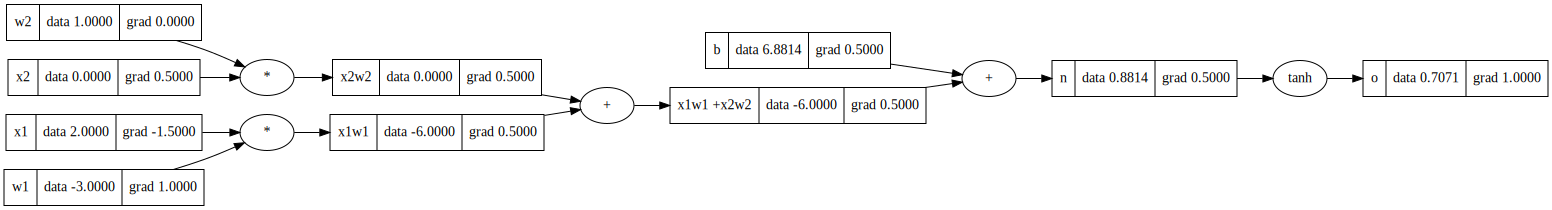

In [85]:
draw_dot(o)

### tanh Fonksiyonunun Manuel Hesaplandığı Tek Nöron Örneği
Bu kod, önceki nöron örneğiyle aynı hesaplamayı yapar ancak `tanh` fonksiyonu doğrudan `Value.tanh()` metoduyla değil, **kapalı formülüyle** manuel olarak yazılmıştır.  
Amaç, `Value` sınıfının otomatik türevleme sisteminin, karmaşık fonksiyonlar elle tanımlansa bile doğru çalıştığını göstermek.

---

#### 1. Girdiler ve Parametreler
`x1`, `x2` → girişler,  
`w1`, `w2` → ağırlıklar,  
`b` → bias terimi.  
Hepsi `Value` nesnesi olarak tanımlanmıştır; hem sayısal değer hem gradyan takibi yapılır.

---

#### 2. Lineer Kombinasyon
Girdiler ağırlıklarıyla çarpılır ve bias eklenir:
\[
n = (x_1 \cdot w_1) + (x_2 \cdot w_2) + b
\]
Bu işlem nöronun doğrusal kısmını (pre-activation) oluşturur.

---

#### 3. tanh Aktivasyonunun Elle Hesaplanması
`tanh` fonksiyonu şu şekilde açılmıştır:
\[
\tanh(n) = \frac{e^{2n} - 1}{e^{2n} + 1}
\]
Kodda bu işlem adım adım yapılır:
1. `e = (2 * n).exp()` → \( e^{2n} \) hesaplanır.  
2. `o = (e - 1) / (e + 1)` → formül uygulanarak tanh değeri elde edilir.  

Burada `exp`, `sub`, `add`, `truediv` gibi işlemler `Value` sınıfı operatörleriyle yapıldığı için her adım grafiğe otomatik olarak eklenir ve türevlenebilir hale gelir.

---

#### 4. Geri Yayılım (Backpropagation)
`o.backward()` çağrısı ile zincir kuralı uygulanır:
- Çıkış `o`’dan başlayan gradyan akışı, `exp`, `+`, `-`, `/`, `*` gibi tüm ara işlemlerden geriye doğru yayılır.  
- Her ara değişken (`n`, `e`, `w1`, `x1`, `b`, vb.) kendi `grad` alanına doğru türev değerini alır.  

Bu sayede manuel olarak yazılmış `tanh` formülü bile otomatik türev sistemiyle tamamen uyumlu çalışır.

---

#### 5. Grafiğin Çizimi
`draw_dot(o)` çağrısı, hesaplama zincirini (girdilerden `o` çıktısına kadar tüm işlemleri) görselleştirir.  
Grafikte hem ileri hesap akışı hem de gradyan akışı açık biçimde gözlemlenebilir.

---

**Özet:**  
Bu örnek, `tanh()`’ın kendi fonksiyonunu kullanmadan yalnızca temel işlemler (`exp`, `+`, `-`, `/`) ile tanımlandığında bile otomatik türev mekanizmasının doğru şekilde türev dağıtabildiğini kanıtlar.  
Sonuçta `o = (e^{2n}-1)/(e^{2n}+1)` ifadesiyle elde edilen çıktı ve gradyanlar, önceki `o = n.tanh()` örneğiyle matematiksel olarak aynıdır.


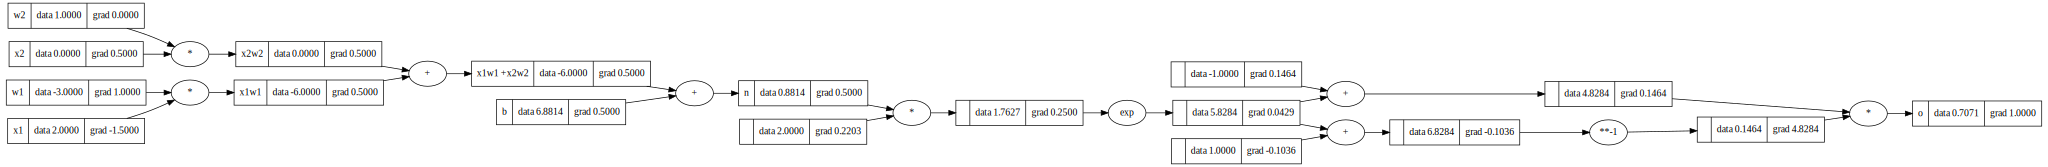

In [87]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 * x2w2 +b
x1w1 = x1*w1 ; x1w1.label= 'x1w1'
x2w2 = x2*w2 ; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 +x2w2'
n = x1w1x2w2 +b; n.label= 'n'
#------
e= (2*n).exp()
o= (e-1)/(e+1)
#-------
o.label = 'o'
o.backward()
draw_dot(o)

In [93]:
import torch

### PyTorch ile Tek Nöronun Otomatik Türev Hesabı
Bu kod, daha önce `Value` sınıfıyla manuel olarak oluşturulan nöron örneğinin aynı işlemini **PyTorch** kullanarak gerçekleştirir.  
Amaç, PyTorch’un otomatik türev (autograd) sisteminin aynı matematiksel prensiplerle çalıştığını doğrulamaktır.

---

#### 1. Değişkenlerin Tanımlanması
Tüm değişkenler (`x1`, `x2`, `w1`, `w2`, `b`) `torch.Tensor` olarak oluşturulur.  
Her biri `.requires_grad = True` ile işaretlenir — böylece PyTorch bu tensörlerde yapılan işlemleri kaydeder ve türev takibi yapar.

---

#### 2. İleri Geçiş (Forward Pass)
Lineer kombinasyon hesaplanır:
\[
n = x_1 \cdot w_1 + x_2 \cdot w_2 + b
\]
Ardından `tanh` aktivasyonu uygulanır:
\[
o = \tanh(n)
\]
Bu, nöronun çıktısını (aktivasyon değerini) üretir.  
`print(o.data.item())` ifadesiyle bu değerin skalar karşılığı ekrana yazdırılır.

---

#### 3. Geri Yayılım (Backward Pass)
`o.backward()` çağrısı yapıldığında PyTorch:
- Hesap grafiğini otomatik olarak geriye doğru dolaşır.
- Zincir kuralını kullanarak her parametrenin `o` çıktısına göre türevini hesaplar.  
- Sonuçlar `x1.grad`, `x2.grad`, `w1.grad`, `w2.grad`, `b.grad` alanlarına otomatik olarak doldurulur.

---

#### 4. Sonuçların İncelenmesi
Her bir parametrenin gradyanı yazdırılır:
- `x2.grad`, `w2.grad`, `x1.grad`, `w1.grad` değerleri,  
  her parametrenin `o` üzerindeki etkisini nicel olarak gösterir.

---

#### Özet
Bu örnek, `Value` sınıfıyla manuel oluşturulan hesap grafiğinin PyTorch tarafından otomatik olarak yapıldığını kanıtlar:
- **İleri geçiş:** `n = x1*w1 + x2*w2 + b`, `o = tanh(n)`  
- **Geri geçiş:** `o.backward()` ile tüm türevlerin otomatik hesaplanması.  

Sonuç olarak PyTorch’un `autograd` sistemi, aynı matematiksel zincir kuralı mantığını kullanarak tüm gradyanları doğru şekilde üretir.


In [94]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Sinir Ağı Yapısının Tanımlanması (`Neuron`, `Layer`, `MLP`)
Bu bölüm, tamamen `Value` sınıfı üzerine kurulu küçük bir yapay sinir ağı mimarisi tanımlar. Amaç: ileri beslemeli (feed-forward) bir MLP (Multi-Layer Perceptron) kurmak, çıktı üretebilmek ve parametreleri (ağırlıklar/bias) optimize edilebilir halde tutmaktır.

---

#### `class Neuron`
Tek bir nöronu temsil eder.

- `__init__(self, nin)`  
  - `nin`: nöronun kaç giriş alacağını belirtir.  
  - `self.w`: her giriş için bir ağırlık (`Value`) oluşturulur, rastgele `[-1, 1]` aralığında başlatılır.  
  - `self.b`: tek bir bias parametresi oluşturulur (yine rastgele).  
  Bu sayede nöronun öğrenilebilir parametreleri `w` (ağırlıklar) ve `b` (bias) olur.

- `__call__(self, x)`  
  Bu metod nöronu çalıştırır (forward pass).  
  - `x`: giriş vektörü (her eleman `Value` olmalı).  
  - `zip(self.w, x)` ile her giriş `xi` ilgili ağırlık `wi` ile çarpılır.  
  - `sum((wi*xi ...), self.b)` ifadesiyle tüm `wi*xi` terimleri toplanır ve bias `b` eklenir:  
    \[
    \text{act} = \sum_i w_i \cdot x_i + b
    \]
  - `act.tanh()` çağrısı ile aktivasyon fonksiyonu (`tanh`) uygulanır.  
  - Sonuç `out` olarak döndürülür. Bu değer nöronun çıktısıdır.  
  Bu işlem klasik tek nöron denklemidir: doğrusal birleşim + doğrusal olmayan aktivasyon.

- `parameters(self)`  
  Bu metod, nöronun öğrenilebilir tüm parametrelerini döndürür: ağırlıklar (`self.w` listesindeki tüm `Value` nesneleri) ve bias (`self.b`).  
  Eğitim sırasında gradyan güncellemesi bu liste üzerinden yapılır.

---

#### `class Layer`
Bir layer (katman), birden fazla nörondan oluşur.

- `__init__(self, nin, nout)`  
  - `nin`: bu katmana giren feature sayısı.  
  - `nout`: bu katmandaki nöron sayısı.  
  - `self.neurons`: `nout` adet `Neuron(nin)` oluşturulur.  
    Yani bu katman, aynı giriş boyutunu kullanan paralel nöronlardan oluşur.

- `__call__(self, x)`  
  - Bu metod, katmanın forward pass’ini yapar.  
  - Her nöron ayrı ayrı `n(x)` şeklinde çağrılır ve kendi çıktısını üretir.  
  - Tüm nöronların çıktıları `outs` listesinde toplanır.  
  - Eğer katman tek nörondan oluşuyorsa (`len(outs) == 1`), doğrudan o tek değeri döndürür; aksi halde çıktı bir liste olarak döner.  
  Bu tasarım, son katmanın tek çıktı üretmesi durumunda gereksiz liste sarmalamasını engeller.

- `parameters(self)`  
  - Katmandaki her nöronun `parameters()` listesini düzleştirir.  
  - Sonuç: bu layer içindeki tüm ağırlıklar ve bias değerleri tek bir listede tutulur.  
  Bu, eğitim döngüsünde tüm parametreleri birlikte optimize edebilmek için gerekir.

---

#### `class MLP`
`MLP` (Multi-Layer Perceptron), birden fazla katmanı arka arkaya bağlayarak tam bir ağ oluşturur.

- `__init__(self, nin, nouts)`  
  - `nin`: ilk katmanın giriş boyutu (örneğin kaç feature var).  
  - `nouts`: her katmanın kaç nöron içereceğini belirten liste.  
    Örnek: `MLP(3, [4, 4, 1])` demek:  
    - Giriş boyutu 3,  
    - İlk gizli katman 4 nöron,  
    - İkinci gizli katman 4 nöron,  
    - Çıkış katmanı 1 nöron.  
  - `sz = [nin] + nouts` ile katmanlar arasındaki giriş/çıkış boyutları hesaplanır.  
    Ardından `self.layers`, her bitişik boyut çifti için bir `Layer(sz[i], sz[i+1])` oluşturarak doldurulur.  
    Yani bu sınıf aslında bir `Layer` zinciri kurar.

- `__call__(self, x)`  
  Bu metod ağın forward pass’ini yapar.  
  - Girdi `x`, sırayla her layer'a beslenir:  
    ```python
    for layer in self.layers:
        x = layer(x)
    ```
  - Her katmanın çıktısı bir sonrakinin girdisi olur.  
  - En sonda elde edilen değer (veya değerler) modelin tahminidir.  
  Bu, klasik ileri beslemeli (feed-forward) hesaplama akışıdır.

- `parameters(self)`  
  - Bütün katmanların parametre listelerini tek bir liste halinde birleştirir.  
  - Sonuç olarak ağın tüm eğitilebilir parametrelerine (`tüm w’ler ve b’ler`) tek noktadan erişmek mümkün olur.  
  Eğitim döngüsünde gradient descent uygulanırken bu liste üzerinde dolaşılarak ağırlıklar güncellenir.

---

#### Genel Akış
- `Neuron` → tek nöronun iç yapısı (ağırlıklar, bias, tanh aktivasyonu).  
- `Layer` → birden çok nöronu paralel olarak çalıştıran yapı.  
- `MLP` → birden fazla layer’ı ardışık bağlayarak çok katmanlı ağı (multi-layer perceptron) oluşturan yapı.

Bu tasarım sayesinde:
1. Rastgele başlatılmış parametrelerle bir MLP modeli oluşturulabilir.  
2. Her `__call__` ile ileri hesap yapılabilir.  
3. `parameters()` ile tüm parametreler toplanıp `grad` değerleri üzerinden elle güncellenerek eğitilebilir.


In [123]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

### MLP Modelinin Çalıştırılması (İleri Besleme - Forward Pass)
Bu kod, tanımlanmış sinir ağı sınıflarını (Neuron, Layer, MLP) kullanarak örnek bir ileri geçiş işlemi yapar.  
Amaç, verilen giriş vektörünün (`x`) çok katmanlı ağdan geçirilip bir çıktı üretilmesidir.

---

#### 1. Girdi Vektörü
`x = [2.0, 3.0, -1.0]`  
Bu liste modelin girişidir. Üç adet sayısal özellik (feature) içerir.  
Her eleman, MLP’nin ilk katmanındaki nöronlara girdi olarak verilir.

---

#### 2. Modelin Oluşturulması
`n = MLP(3, [4, 4, 1])`  
Bu satır, 3 girişli ve sırasıyla 4, 4 ve 1 nöron içeren 3 katmanlı bir **Multi-Layer Perceptron (MLP)** oluşturur:

- **1. Katman:** 3 giriş → 4 nöron  
- **2. Katman:** 4 giriş → 4 nöron  
- **3. Katman (çıkış):** 4 giriş → 1 nöron  

Her nöronun ağırlıkları (`w`) ve bias’ı (`b`) rastgele başlatılır, `Value` sınıfı sayesinde her işlem türevlenebilir durumdadır.

---

#### 3. Modelin Çalıştırılması
`n(x)` çağrısı, ağın ileri besleme (forward pass) işlemini başlatır:

- Girdi `x`, ilk katmandaki her nörona gönderilir.  
- Her katman, çıktısını `tanh` aktivasyonundan geçirip bir sonraki katmana aktarır.  
- Son katman tek bir `Value` nesnesi üretir; bu ağın nihai çıktısıdır.  

Matematiksel olarak:
\[
\text{output} = \tanh(W_3 \cdot \tanh(W_2 \cdot \tanh(W_1 \cdot x + b_1) + b_2) + b_3)
\]

---

#### 4. Çıktı
`n(x)` ifadesi, ağın tahmini değerini döndürür.  
Bu aşamada model rastgele ağırlıklarla başlatıldığı için çıktı rastgeledir; eğitim yapılmadan anlamlı bir tahmin değildir.  
Ancak bu çağrı, tüm katmanların doğru şekilde bağlandığını ve ağın hesap grafiğini oluşturduğunu doğrular.

---

**Özet:**  
Bu kod, 3 girişli, 2 gizli katmanlı ve 1 çıkışlı bir MLP oluşturur, verilen `x` vektörünü ağa uygular ve ileri besleme sonucunda bir `Value` nesnesi çıktısı üretir.  
Ağın her hesap adımı kayıt altına alındığından, daha sonra `backward()` çağrısı ile tüm parametrelerin gradyanları hesaplanabilir.


In [142]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5413464004291535)

### Eğitim Verisinin (Dataset) Tanımlanması
Bu blok, MLP modelinin öğrenmesi için kullanılacak giriş verilerini (`xs`) ve hedef çıktılarını (`ys`) tanımlar.

---

#### 1. Girişler (`xs`)
`xs`, her elemanı bir örnek (sample) olacak şekilde 4 adet giriş vektörü içerir:

- `[2.0, 3.0, -1.0]`
- `[3.0, -1.0, 0.5]`
- `[0.5, 1.0, 1.0]`
- `[1.0, 1.0, -1.0]`

Her vektör, modelin göreceği özellikleri (feature'ları) temsil eder.  
Burada her örnek 3 boyutlu bir girdi uzayında tanımlıdır, yani model 3 girişli olacak şekilde eğitilecektir.

Bu yapı denetimli öğrenme için klasik giriş matrisi gibi çalışır:  
\[
X = \{ x^{(1)}, x^{(2)}, x^{(3)}, x^{(4)} \}
\]
her \( x^{(i)} \) üç özellikten oluşur.

---

#### 2. Hedefler (`ys`)
`ys = [1.0, -1.0, -1.0, 1.0]`

Bu liste, her giriş örneği için beklenen çıktıyı (etiketi) belirtir.  
Yani:
- `[2.0, 3.0, -1.0]` → hedef `1.0`
- `[3.0, -1.0, 0.5]` → hedef `-1.0`
- `[0.5, 1.0, 1.0]` → hedef `-1.0`
- `[1.0, 1.0, -1.0]` → hedef `1.0`

Bu değerler sınıflandırma benzeri bir görev için etiket gibi davranır (örneğin “pozitif sınıf = 1.0”, “negatif sınıf = -1.0”).

---

#### Özet
`xs` modelin girdi örneklerini, `ys` bu girdilere karşılık beklenen çıktıları tutar.  
Bu çiftler, ileri besleme sonucunda modelin tahmini ile gerçek hedef arasındaki hatayı (loss) hesaplamak ve daha sonra gradyan inişiyle ağı eğitmek için kullanılacaktır.


In [144]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Modelin Başlangıç Tahminlerinin Hesaplanması
Bu blok, eğitilmemiş (rastgele ağırlıklara sahip) MLP modelinin her giriş örneği için yaptığı tahminleri hesaplar.

---

#### 1. Kodun İşleyişi
`ypred = [n(x) for x in xs]`  
Bu ifade, `xs` listesindeki her giriş vektörü (`x`) için modeli (`n`) çağırır ve çıktıları toplar:

- Döngü her iterasyonda bir `x` örneğini alır.  
- `n(x)` çağrısı o örneği ağdan geçirir → ileri besleme (forward pass).  
- Sonuç, o örnek için modelin ürettiği tahmin (`Value` nesnesi) olur.  
- Tüm tahminler `ypred` listesinde toplanır.

---

#### 2. `ypred` İçeriği
`ypred` modeli test etmeden önceki tahmin listesidir.  
Her eleman, ağın belirli bir giriş için ürettiği çıkışı (aktivasyon değerini) temsil eder.  
Bu değerler şu aşamada **anlamsal olarak doğru değildir**, çünkü model henüz eğitilmemiştir; yalnızca ağırlıkların rastgele başlatılması sonucu oluşur.

---

#### 3. Amaç
Bu işlem, modelin “sıfırıncı adımda” (eğitim öncesi) çıktısını görmeyi sağlar.  
Elde edilen sonuçlar, daha sonra eğitim döngüsünden sonra (loss azaldıkça) nasıl değiştiğini gözlemlemek için karşılaştırma noktası olarak kullanılır.

---

**Özet:**  
`ypred = [n(x) for x in xs]` ifadesi, veri kümesindeki her giriş için modelin başlangıç tahminlerini üretir.  
`ypred` modeli çalışır durumda test eder; ağın bağlantıları ve hesap grafiği doğru kurulmuşsa her giriş örneği için bir `Value` tipi çıktı üretir.


In [146]:
ypred =[n(x) for x in xs]
ypred

[Value(data=0.5413464004291535),
 Value(data=-0.6747831509164348),
 Value(data=-0.07323294967873993),
 Value(data=-0.23189165599193573)]

### MLP Modelinin Eğitimi (Gradient Descent Döngüsü)
Bu kod, MLP modelini 20 iterasyon boyunca gradyan inişi (gradient descent) yöntemiyle eğitir. Her iterasyonda model tahmin üretir, hata hesaplar, gradyanları çıkarır ve parametreleri günceller.  

for k in range(20):  
→ 20 kez (epoch) tekrarlanan eğitim döngüsünü başlatır.  

# Forward pass  
ypred = [n(x) for x in xs]  
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  
→ Model tüm girişler için tahminler üretir.  
→ Tahminlerle gerçek değerler arasındaki fark karelerinin toplamı alınarak “loss” değeri hesaplanır:  
loss = Σ(y_pred − y_true)²  
Bu, modelin hatasını ölçen klasik Mean Squared Error (MSE)’dir.  

# Backward pass  
for p in n.parameters(): p.grad = 0.0  
loss.backward()  
→ Önce tüm parametrelerin gradyanları sıfırlanır.  
→ Ardından loss.backward() çağrısı ile zincir kuralı uygulanarak her parametrenin loss’a göre türevi (∂loss/∂p) hesaplanır.  

# Update  
for p in n.parameters(): p.data += -0.1 * p.grad  
→ Gradyan değerleri kullanılarak her parametre, hatayı azaltacak yöne doğru güncellenir:  
p = p − η * ∂loss/∂p  
Burada η = 0.1 öğrenme oranıdır.  

print(k, loss.data)  
→ Her iterasyon sonunda loss değeri ekrana yazdırılır. Loss azaldıkça model veriye daha iyi uyum sağlar.  

Sonuç olarak bu döngü, üç adımlı klasik eğitim sürecini (forward, backward, update) manuel olarak uygular ve 20 iterasyon sonunda modelin hatasını azaltır.


In [148]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 2.6925833409908595
1 0.9935575376214104
2 0.537778341387753
3 0.15486980017361185
4 0.08645553541397019
5 0.06638471526537454
6 0.05504316155254027
7 0.04735624586258387
8 0.04166385725634392
9 0.037225210587632125
10 0.033645107879166226
11 0.030686948980486767
12 0.02819748877097404
13 0.0260717472409036
14 0.02423475493337951
15 0.022631233085413135
16 0.02121937155800909
17 0.019966882436330224
18 0.01884839333912245
19 0.017843667725803775


In [150]:
ypred

[Value(data=0.9537036417901162),
 Value(data=-0.9192369779864753),
 Value(data=-0.9361806085381175),
 Value(data=0.9285525753369387)]

Bu satır, modelin hesap grafiğini (computational graph) kayıp fonksiyonu (`loss`) üzerinden görselleştirir.  

draw_dot(loss)  
→ `loss` değişkeni, tüm ileri hesaplamaların (x → n(x) → ypred → loss) en uç noktasıdır.  
→ `draw_dot()` fonksiyonu, `loss` düğümünden başlayarak grafiğin tüm düğümlerini ve bağlantılarını geriye doğru takip eder.  
→ Her `Value` nesnesi bir kutu olarak gösterilir; içinde:  
   - label (değişken adı)  
   - data (sayısal değer)  
   - grad (gradyan değeri) bulunur.  
→ Aritmetik işlemler (`+`, `*`, `tanh`, vb.) ayrıca düğüm olarak çizilir ve oklarla hangi değerlerin hangi işlemlere girdiği gösterilir.  

Bu görselleştirme, modelin ileri ve geri yayılımda hangi değişkenlerin birbirine bağlı olduğunu anlamak için kullanılır.  
Kısacası `draw_dot(loss)`, eğitim sürecinin tüm matematiksel zincirini görsel olarak temsil eder.


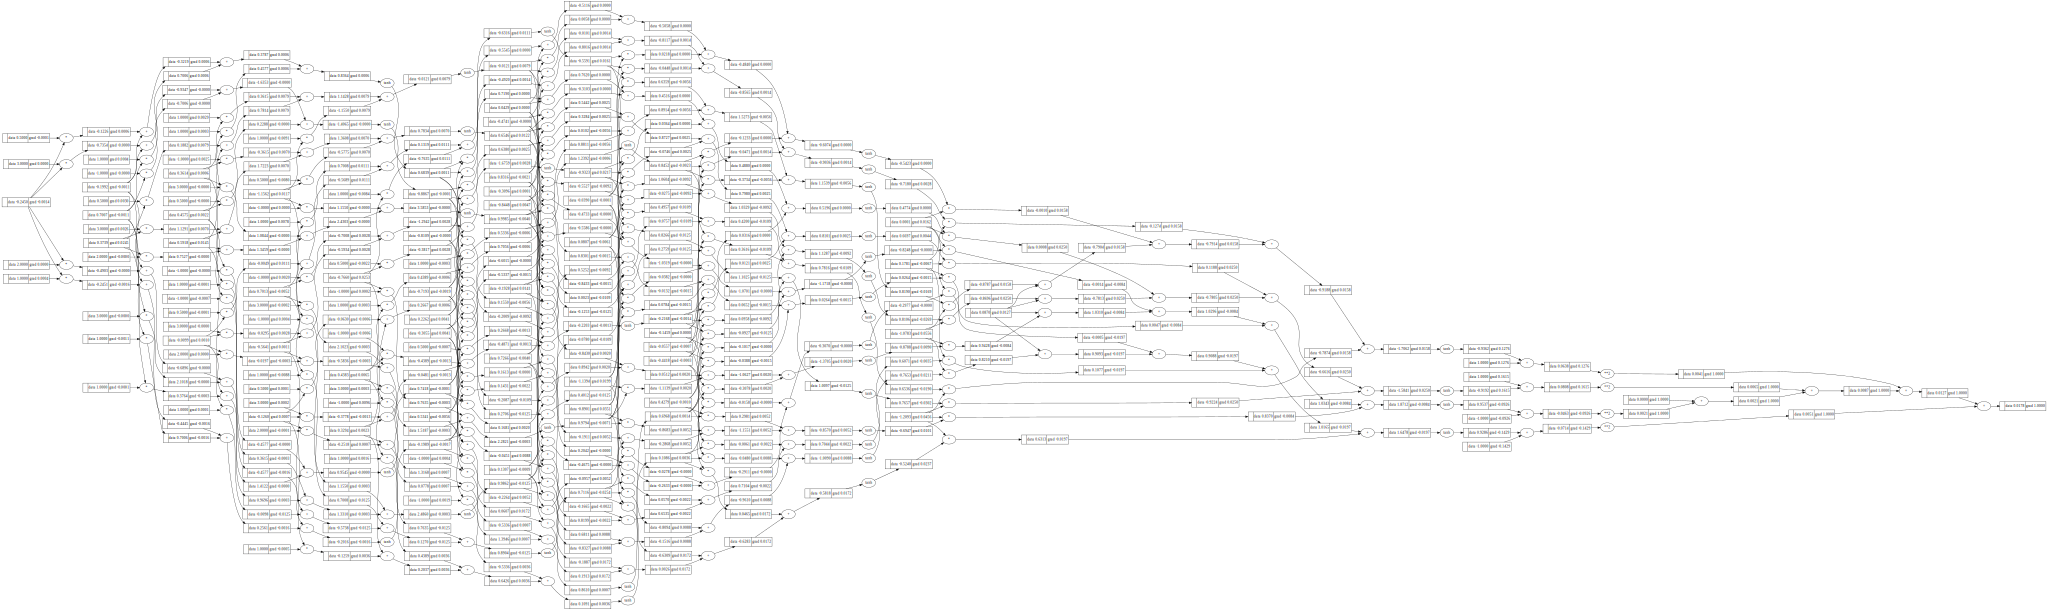

In [152]:
draw_dot(loss)